# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [39]:
boston = pd.read_csv('boston_data.csv')

#dtypes say all columns are floats
boston.dtypes

#check for nulls: no nulls
boston.isna().sum()

boston.head()

<IPython.core.display.Javascript object>

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [40]:
boston.drop('rad', axis = 1, inplace = True)

### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

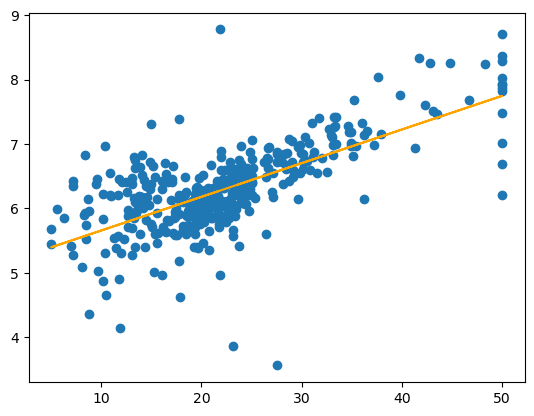

In [41]:
from sklearn.linear_model import LinearRegression

x = pd.DataFrame(boston['medv'])
y = pd.DataFrame(boston['rm'])

mod = LinearRegression()
mod.fit(x,y)

slope = mod.coef_
interception = mod.intercept_

reg_line = interception + slope*x
plt.plot(x, reg_line, c="orange")
plt.scatter(x,y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

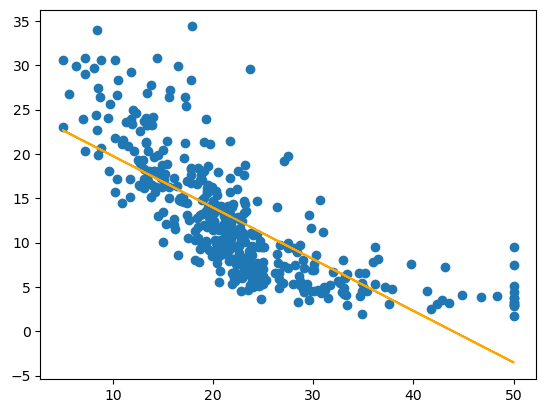

In [42]:
x = pd.DataFrame(boston['medv'])
y = pd.DataFrame(boston['lstat'])

mod = LinearRegression()
mod.fit(x,y)

slope = mod.coef_
interception = mod.intercept_

reg_line = interception + slope*x
plt.plot(x, reg_line, c="orange")
plt.scatter(x,y)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

In [43]:
# wasn't expecting to see anti correlation between lstat and the house prices, but they're still correlated somehow
# correlation was expected for both

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

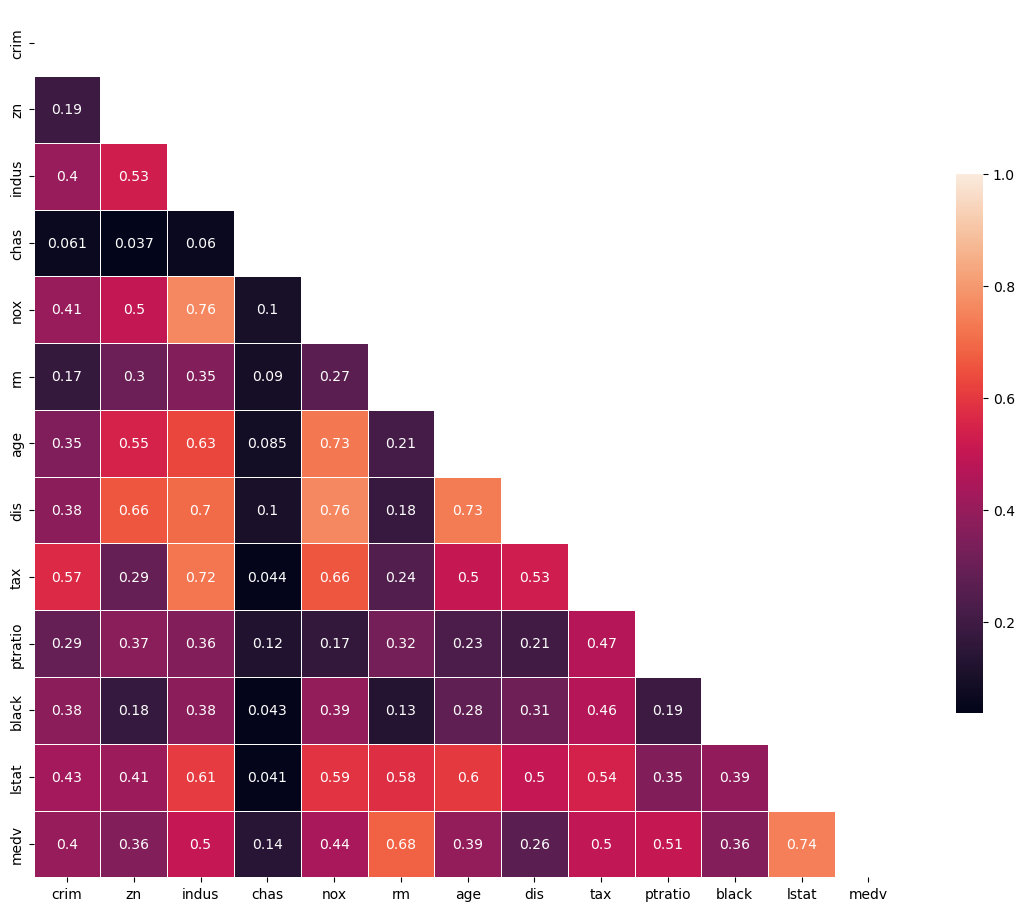

In [44]:
import matplotlib.pyplot as plt
import seaborn as sn

corr=np.abs(boston.corr())

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(14, 14))
cmap = sn.diverging_palette(220, 10, as_cmap=True)
sn.heatmap(corr, mask=mask,  vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = corr)

plt.show()

In [45]:
# yes. tax and ptratios

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [46]:
boston.describe()['medv']

count    404.000000
mean      22.312376
std        8.837019
min        5.000000
25%       17.100000
50%       21.400000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [47]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return r2_score(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [48]:
features = boston.drop('medv', axis = 1)
target = boston['medv']

x_train, x_test, y_train, y_test = train_test_split(features, target, random_state = 0)

<IPython.core.display.Javascript object>

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [49]:
from sklearn.ensemble import RandomForestRegressor

randforest2 = RandomForestRegressor(max_depth = 2)
randforest2.fit(x_train,y_train)

randforest4 = RandomForestRegressor(max_depth = 4)
randforest4.fit(x_train,y_train)

randforest6 = RandomForestRegressor(max_depth = 6)
randforest6.fit(x_train,y_train)

randforest8 = RandomForestRegressor(max_depth = 8)
randforest8.fit(x_train,y_train)

randforest10 = RandomForestRegressor(max_depth = 10)
randforest10.fit(x_train,y_train)

randforest12 = RandomForestRegressor(max_depth = 12)
randforest12.fit(x_train,y_train)

RandomForestRegressor(max_depth=12)

Now, plot the score for each tree on the training set and on the testing set.

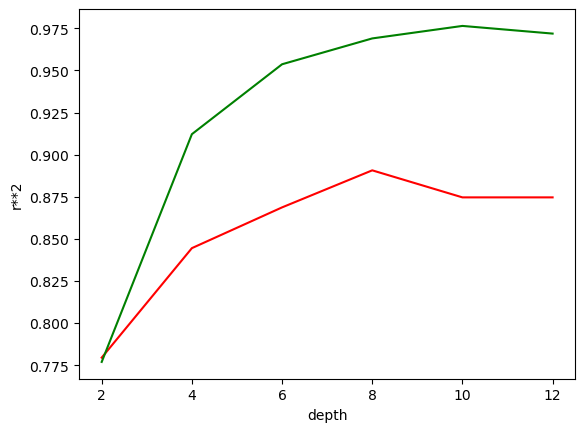

In [50]:
test_score = []
test_score.append(randforest2.score(x_test,y_test))
test_score.append(randforest4.score(x_test,y_test))
test_score.append(randforest6.score(x_test,y_test))
test_score.append(randforest8.score(x_test,y_test))
test_score.append(randforest10.score(x_test,y_test))
test_score.append(randforest10.score(x_test,y_test))

training_score = []
training_score.append(randforest2.score(x_train,y_train))
training_score.append(randforest4.score(x_train,y_train))
training_score.append(randforest6.score(x_train,y_train))
training_score.append(randforest8.score(x_train,y_train))
training_score.append(randforest10.score(x_train,y_train))
training_score.append(randforest12.score(x_train,y_train))

x_values = [2, 4, 6, 8, 10, 12]

plt.plot(x_values, test_score, c = 'red')
plt.plot(x_values, training_score, c = 'green')
plt.xlabel('depth')
plt.ylabel('r**2')
plt.show()

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [51]:
# as deeper it goes, the r**2 improves, but we also notice a case of overfitting from depth 4 onwards
# so, in my opinion, the best depth would be 2 or 3.

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [52]:
# a model trained with a maximum depth of 10 is highly overfitted, so will suffer from high variance and will
# pay a lot of attention to the training data and won't have the capability to generalize to new data

# model with maximum depth of 1 will pay little attention to the the training data and because of that
# will oversimplify the predictions given new data, leading to a high error on training a test data (low r**2)

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [53]:
# the max_depth would be 2 because even though is the low point for r**2 is where there's no overfitting nor
# underfitting so the model will adapt well to new data even if with a margin of error that we can
# calculare, expect and work with it

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [56]:
#1. data possibly is not that relevant because in a timeframe of more than 40years prices may have change due to
#   a lot of reasons: tourism, gentrification, globalization

#2. i would say so because how evenly well correlated 'medv' is with a lot of features

#3. probably not, we could search for hyperparameters on random forest and try to cross validate

#4. of course not. variables - that can be quantified or not - applied to develop a model on a urban city 
#   won't apply on rural cities